In [4]:
import pandas as pd
import numpy as np
import math
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression
import seaborn as sns
#import pyfolio
import datetime
from sklearn.cluster import MeanShift, estimate_bandwidth
%matplotlib inline

In [54]:
def load_symbol(filename):
# Load symbol and get quotes, datetimes and volumes
    df_cur = pd.read_csv(filename)
    cur_col1 = df_cur.iloc[:, 4].values
    cur_index = df_cur.iloc[:, 0].values
    cur_volume = df_cur.iloc[:, 5].values
    
    return cur_col1, cur_index, cur_volume


def importSupportResistance(values_, quantile_, n_samples_):
# ml_strats/ordercompute mod
    # Removes values that are too close. Requires sorted list
    def cleanLevelFloats(ml_results_):
        for j in range(100):
            last_results = ml_results_
            for i in range(1, len(ml_results_)-1):
                # 0.001 is for symbols with a normal range within <0,10>. Multiply for f.ex. USDJPY
                if ml_results_[i] - ml_results_[i-1] < 50 or ml_results_[i+1] - ml_results_[i-1] < 50:
                    ml_results_[i] = 0
            ml_results_ = list(filter(lambda a: a != 0, ml_results_))
            if last_results == ml_results_:
                break
        return ml_results_

    # Import data and convert to matrix for bandwidth
    '''
    input_train_ = getDayRates.getDayRates(symbol_, date_)
    rate_data = getDayRates.importRates(input_train_)
    '''

    bw_data = values_#.as_matrix()

    # Calculate bandwidth and fit data
    # Greater quantile greater sample size. estimate_bandwidth for faster MeanShift processing
    bandwidth = estimate_bandwidth(bw_data, quantile=float(quantile_), n_samples=int(n_samples_))

    # Bin seeding for increased execution speed but fewer seeds, n_jobs=-2 for all but one active cpu core
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=-2)
    ms.fit(values_)

    # Append maximas of all clusters to S/R array
    ml_results = []
    for k in range(len(np.unique(ms.labels_))):
        members = ms.labels_ == k
        values = bw_data[members, 0]
        ml_results.append(min(values))
        ml_results.append(max(values))

    # Remove duplicates and clean floats
    rnd_ml_results = [round(elem, 4) for elem in ml_results]
    #rnd_ml_results = list(set(rnd_ml_results))

    return cleanLevelFloats(sorted(rnd_ml_results))

In [55]:
def drop_zeros(index, rates, volume):
# Drops weekend values
    jj = 0
    for j in range(len(volume)):
        if volume[j] > 0:
            rates[jj] = rates[j]
            index[jj] = index[j]
            volume[jj] = volume[j]
            jj += 1

    rates = rates[:jj]
    index = index[:jj]
    volume = volume[:jj]

    return index, rates, volume

In [101]:
rates, index, volume = load_symbol('data/EURUSD_Candlestick_5_m_BID_02.01.2012-26.06.2017.csv')
index, rates, volume = drop_zeros(index, rates, volume)

volume = volume.reshape(-1, 1)
quantile_ = 0.125
n_samples_ = 1000
sr_levels = importSupportResistance(volume[:2880], quantile_, n_samples_)

02.01.2012 00:00:00.000
16.01.2012 00:00:00.000


11.25
805.97
1141.17
2077.24
2914.45


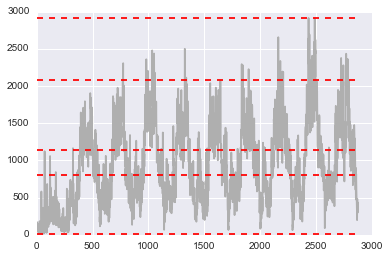

In [102]:
print(index[0])
print(index[2880])
print('\n')

plt.plot(volume[:2880], '#afafaf')
for i in range(len(sr_levels)):
    plt.plot((0, len(volume[:2880])), (sr_levels[i], sr_levels[i]), 'r--')
    print(sr_levels[i])
plt.show()

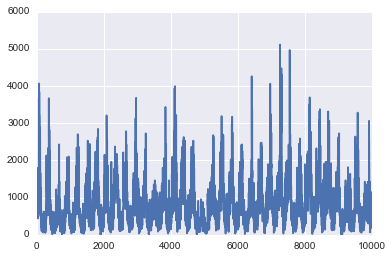

312.5
appx. 1.083 days in avg cycle


In [73]:
plt.plot(volume[99999:110000])
plt.show()

counter = 0
for i in range(110000-99999):
    if volume[i] > 1500:
        counter += 1

print(5000/32*2)
print('appx. %.3f days in avg cycle' % float(312*5/60/24))

period length is appx 1 day, peaking in london session

06.01.2012 22:55:00.000


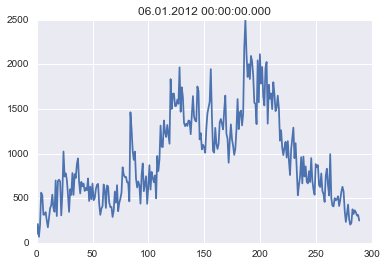

In [100]:
plt.plot(volume[1140:1430])
plt.title(index[1152])
print(index[1427])

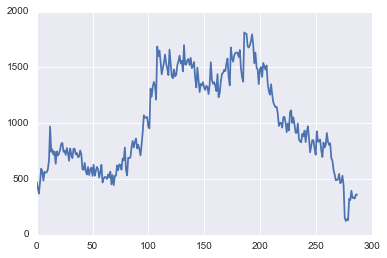

In [131]:
days_ = [0]*288
n5 = 0
for i in range(1152, 4030):
    if index[i].split(' ')[1] == '00:00:00.000':
        n5 = 0
    days[n5] += volume[i]
    n5 += 1
    
days = [days[i]/10 for i in range(288)]

plt.plot(days)

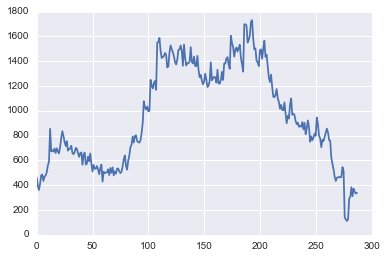

In [156]:
days = [0]*288
n5 = 0
for i in range(1152, 6910):
    if index[i].split(' ')[1] == '00:00:00.000':
        n5 = 0
    days[n5] += volume[i]
    n5 += 1
    
days = [days[i]/20 for i in range(288)]

plt.plot(days)

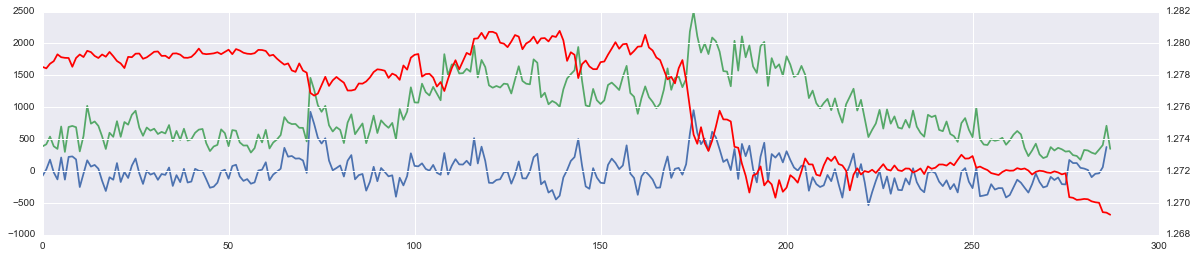

In [164]:
delta = [volume[1152+i] - days[i] for i in range(287)]
fig = plt.figure(figsize=(20, 4))
a = fig.add_subplot(111)
a.plot(delta)
a.plot(volume[1152:1440])
a.twinx().plot(rates[1152:1440], 'r')
plt.show()